In [1]:
# Install the Prophet
!pip install prophet

In [2]:
# Import the required libraries and dependencies
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from prophet import Prophet
import yfinance as yf
import os
import csv

In [3]:
import warnings
# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
# Set crypto variable
crypto = 'ATOM'
yf_crypto = 'ATOM'

# Set YF crypto symbol
symbol = f'{yf_crypto}-USD'

# Create crypto df
#crypto_df = f'{crypto}_df'.lower()

In [5]:
# Retreive max data
data = yf.Ticker(f'{symbol}')
history = data.history(period='max')

# Define file path and name
#filepath = f'~/crypto-forecast/resources/{crypto}-USD.csv'
#filepath = os.path.expanduser('~/crypto-forecast/resources/ADA-USD.csv')

# Create dataframe
crypto_df = pd.DataFrame(history)

# Set 'Date' as the index and parse dates
crypto_df.index = pd.to_datetime(crypto_df.index)

# Drop columns
crypto_df.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

# Drop last row
crypto_df = crypto_df.drop(crypto_df.tail(1).index)

# Drop rows with any NaN values
crypto_df.dropna(inplace=True)

# Sort by ascending date
crypto_df = crypto_df.sort_values(by="Date", ascending=True)

# Drop timezone from datetime
crypto_df = crypto_df.reset_index()
crypto_df['Date'] = crypto_df['Date'].dt.tz_localize(None)
crypto_df.set_index('Date', inplace=True)

# Set file path to store data as a csv
csv_filepath = os.path.expanduser(f'~/crypto-forecast/resources/{crypto}-USD.csv')

# Write the DataFrame to a CSV file
crypto_df.to_csv(csv_filepath, index=True)

# Review the first and last five rows of the DataFrame
display(crypto_df.head())
display(crypto_df.tail())

,Open,High,Low,Close,Volume
Date,,,,,
2019-03-14,6.439715,6.639943,6.353963,6.526642,7318172
2019-03-15,6.633174,7.715249,6.432468,7.504351,6057301
2019-03-16,7.507990,8.305615,6.694531,7.383882,3477393
2019-03-17,7.357443,7.357443,4.727895,4.776164,2653565
2019-03-18,4.828242,5.229982,4.828242,5.110341,2567201


,Open,High,Low,Close,Volume
Date,,,,,
2024-06-04,8.336576,8.539986,8.301442,8.535199,95694758
2024-06-05,8.535205,8.728137,8.500226,8.692577,101131154
2024-06-06,8.692935,8.793395,8.573470,8.617699,111718832
2024-06-07,8.617626,8.690089,7.645950,8.098859,209205882
2024-06-08,8.098445,8.107482,7.726115,7.759524,131377792


In [6]:
# Get last closing price
last_close_df = crypto_df.iloc[-1]
last_close_price = last_close_df['Close']
last_close_price

7.759523868560791

In [7]:
crypto_df.corr()

,Open,High,Low,Close,Volume
Open,1.000000,0.997146,0.995803,0.993417,0.693616
High,0.997146,1.000000,0.994629,0.997148,0.720774
Low,0.995803,0.994629,1.000000,0.996231,0.670234
Close,0.993417,0.997148,0.996231,1.000000,0.703684
Volume,0.693616,0.720774,0.670234,0.703684,1.000000


In [8]:
# Create new df with just Close prices and Volume
df_close = crypto_df[['Close', 'Volume']]

In [9]:
df_close.name = 'Close'
df_close

,Close,Volume
Date,,
2019-03-14,6.526642,7318172
2019-03-15,7.504351,6057301
2019-03-16,7.383882,3477393
2019-03-17,4.776164,2653565
2019-03-18,5.110341,2567201
...,...,...
2024-06-04,8.535199,95694758
2024-06-05,8.692577,101131154
2024-06-06,8.617699,111718832


In [10]:
# Create a copy of the DataFrame to avoid the SettingWithCopyWarning
df_close_ma = df_close.copy()

# Calculate 10-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA10'] = df_close_ma['Close'].rolling(10).mean()

# Calculate 30-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA30'] = df_close_ma['Close'].rolling(30).mean()

# Calculate 50-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA50'] = df_close_ma['Close'].rolling(50).mean()

# Remove NULL values
df_close_ma.dropna(inplace=True)

In [11]:
# Review the first and last five rows of the DataFrame
display(df_close_ma.head())
display(df_close_ma.tail())

,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2019-05-02,4.594658,83803871,3.923099,4.221030,4.288250
2019-05-03,5.310845,161847461,4.041971,4.272493,4.263934
2019-05-04,5.259992,164883490,4.204301,4.322917,4.219047
2019-05-05,4.853705,68292315,4.359221,4.357759,4.168443
2019-05-06,4.725382,63030290,4.468416,4.367026,4.167428


,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2024-06-04,8.535199,95694758,8.477369,8.576277,8.546573
2024-06-05,8.692577,101131154,8.506406,8.559207,8.557066
2024-06-06,8.617699,111718832,8.499258,8.548427,8.568591
2024-06-07,8.098859,209205882,8.437227,8.515484,8.566461
2024-06-08,7.759524,131377792,8.350546,8.470040,8.558403


<Axes: xlabel='Date'>

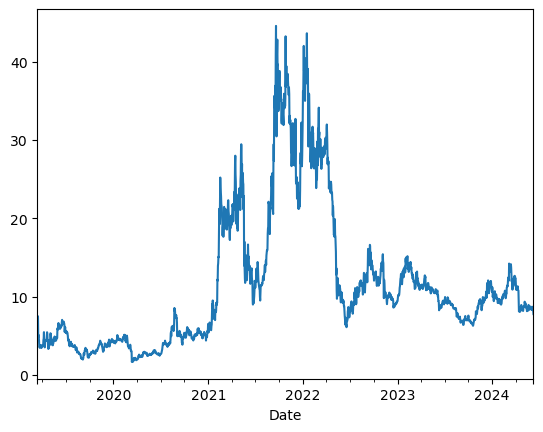

In [12]:
# Plot Close
df_close['Close'].plot()

In [13]:
## Create a Time Series Model with Prophet

In [14]:
# Using the DataFrame, reset the index so the date information is no longer the index
df_close = df_close.reset_index()

In [15]:
# Label the columns ds and y so that the syntax is recognized by Prophet
df_close.rename(columns={'Date':'ds','Close':'y'}, inplace=True)

# Drop an NaN values from the prophet_df DataFrame
df_close.dropna()

# View the first and last five rows of the DataFrame
df_close

,ds,y,Volume
0,2019-03-14,6.526642,7318172
1,2019-03-15,7.504351,6057301
2,2019-03-16,7.383882,3477393
3,2019-03-17,4.776164,2653565
4,2019-03-18,5.110341,2567201
...,...,...,...
1909,2024-06-04,8.535199,95694758
1910,2024-06-05,8.692577,101131154
1911,2024-06-06,8.617699,111718832
1912,2024-06-07,8.098859,209205882


In [16]:
# Call the Prophet function, store as an object
crypto_model = Prophet()

In [17]:
# Fit the time-series model.
crypto_model.fit(df_close)

16:30:09 - cmdstanpy - INFO - Chain [1] start processing
16:30:10 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Create a future dataframe to hold predictions
# Make the prediction go out 30 days
crypto_future = crypto_model.make_future_dataframe(periods = 90, freq = 'd')

# View the last five rows of the DataFrame
crypto_future.tail(5)

,ds
1999,2024-09-02
2000,2024-09-03
2001,2024-09-04
2002,2024-09-05
2003,2024-09-06


In [19]:
# Make the predictions for the data using the DataFrame
crypto_forecast = crypto_model.predict(crypto_future)

# Display the first five rows of the DataFrame
crypto_forecast.tail(30)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1974,2024-08-08,7.791122,0.863912,9.180209,7.329050,8.171297,-2.589875,-2.589875,-2.589875,-0.017858,-0.017858,-0.017858,-2.572018,-2.572018,-2.572018,0.0,0.0,0.0,5.201247
1975,2024-08-09,7.785707,1.252460,9.227837,7.312163,8.195183,-2.445214,-2.445214,-2.445214,0.032730,0.032730,0.032730,-2.477944,-2.477944,-2.477944,0.0,0.0,0.0,5.340493
1976,2024-08-10,7.780293,1.217025,9.704061,7.286111,8.211812,-2.342661,-2.342661,-2.342661,0.042361,0.042361,0.042361,-2.385022,-2.385022,-2.385022,0.0,0.0,0.0,5.437632
1977,2024-08-11,7.774878,1.429454,9.822214,7.254755,8.216265,-2.247748,-2.247748,-2.247748,0.046933,0.046933,0.046933,-2.294681,-2.294681,-2.294681,0.0,0.0,0.0,5.527130
1978,2024-08-12,7.769463,1.316672,9.709969,7.215675,8.215164,-2.224989,-2.224989,-2.224989,-0.016795,-0.016795,-0.016795,-2.208194,-2.208194,-2.208194,0.0,0.0,0.0,5.544474
1979,2024-08-13,7.764049,1.353520,9.668343,7.189554,8.224009,-2.166729,-2.166729,-2.166729,-0.040092,-0.040092,-0.040092,-2.126638,-2.126638,-2.126638,0.0,0.0,0.0,5.597319
1980,2024-08-14,7.758634,1.384258,9.738565,7.160754,8.240142,-2.098132,-2.098132,-2.098132,-0.047280,-0.047280,-0.047280,-2.050852,-2.050852,-2.050852,0.0,0.0,0.0,5.660503
1981,2024-08-15,7.753219,1.336635,10.045273,7.137166,8.257408,-1.999269,-1.999269,-1.999269,-0.017858,-0.017858,-0.017858,-1.981411,-1.981411,-1.981411,0.0,0.0,0.0,5.753951
1982,2024-08-16,7.747805,1.823743,10.144618,7.119944,8.263505,-1.885871,-1.885871,-1.885871,0.032730,0.032730,0.032730,-1.918601,-1.918601,-1.918601,0.0,0.0,0.0,5.861934
1983,2024-08-17,7.742390,1.406446,10.039491,7.086932,8.268768,-1.820043,-1.820043,-1.820043,0.042361,0.042361,0.042361,-1.862404,-1.862404,-1.862404,0.0,0.0,0.0,5.922348


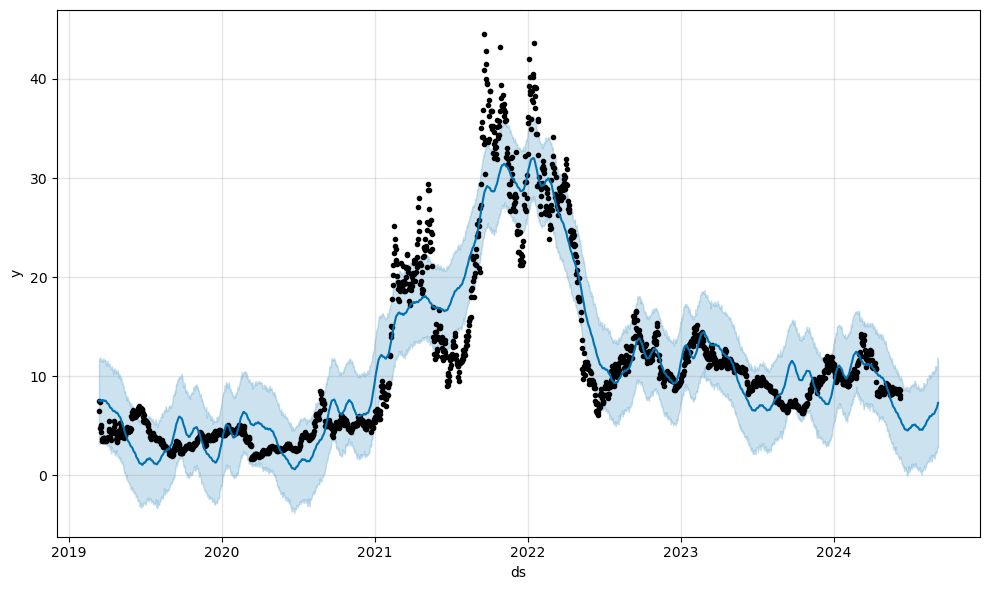

In [20]:
# Plot the Prophet predictions for the data
crypto_model.plot(crypto_forecast)
plt.savefig(f'{crypto}_forecast', bbox_inches = 'tight')

In [21]:
# Set the index in the forecast DataFrame to the ds datetime column
crypto_forecast = crypto_forecast.set_index('ds')

In [22]:
# View only the yhat,yhat_lower and yhat_upper columns from the forecast DataFrame
crypto_forecast[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-90:,:]

,yhat,yhat_lower,yhat_upper
ds,,,
2024-06-09,5.563202,1.883118,9.968120
2024-06-10,5.402569,1.542827,9.696541
2024-06-11,5.282073,1.147610,9.739477
2024-06-12,5.178477,1.185112,9.418286
2024-06-13,5.113469,1.085432,9.384126
...,...,...,...
2024-09-02,6.683941,2.275847,10.936634
2024-09-03,6.784787,2.385723,10.927810
2024-09-04,6.914831,2.822197,11.061435


In [23]:
# Rename columns
crypto_forecast.rename(columns={'yhat':'mid trend price','yhat_lower':'lower trend price','yhat_upper':'upper trend price'}, inplace=True)

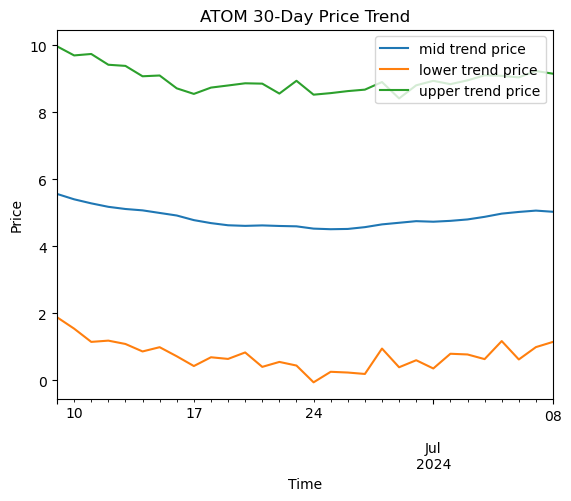

In [24]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-60,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 30-Day Price Trend')    
plt.show()

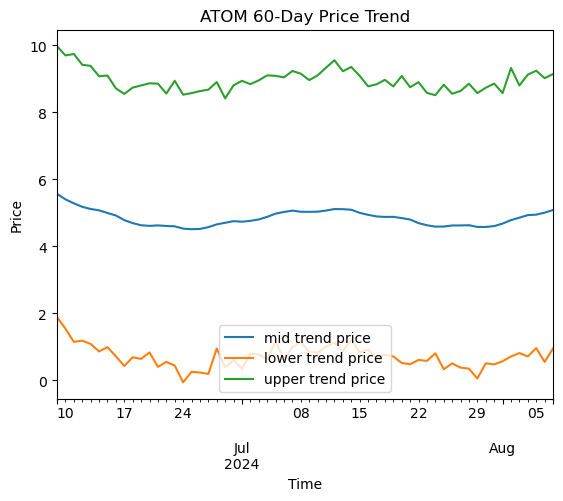

In [25]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-30,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 60-Day Price Trend')    
plt.show()

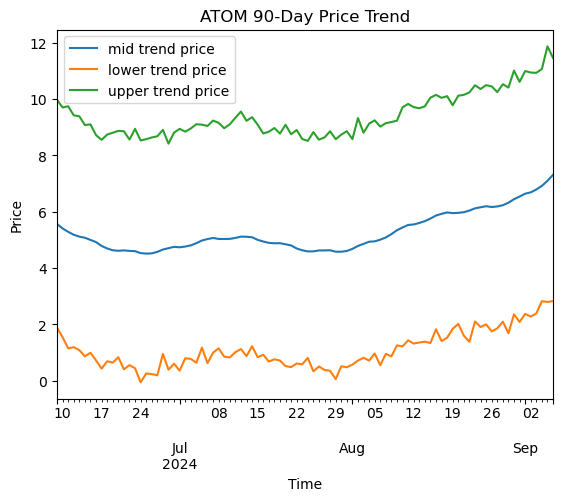

In [26]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 90-Day Price Trend')    
plt.savefig(f'{crypto}_90d_trend_forecast', bbox_inches = 'tight')
plt.show()

In [27]:
# Retrieve last closing price
last_close_price

7.759523868560791

In [28]:
# Retreive tomorrow's mid trend price forecast
tommorow_mid_trend_price = crypto_forecast['mid trend price'].iloc[-90]
tommorow_mid_trend_price

5.563202083004008

In [29]:
# Calculate tommorrow's weighted price
wp = last_close_price*.5 + tommorow_mid_trend_price*.5
wp

6.661362975782399

In [30]:
# Retreive tomorrow's weighted trend price forecast
tommorow_mid_trend_price = ((crypto_forecast['mid trend price'].iloc[-90]*.6)+(crypto_forecast['upper trend price'].iloc[-90]*.2)+(crypto_forecast['lower trend price'].iloc[-90]*.2))
tommorow_mid_trend_price

5.708168817213006

In [31]:
# Retrieve weighted trend price in 30 days
mid_trend_price_in_30 = ((crypto_forecast['mid trend price'].iloc[-60]*.6)+(crypto_forecast['upper trend price'].iloc[-60]*.2)+(crypto_forecast['lower trend price'].iloc[-60]*.2))
mid_trend_price_in_30

4.979068125613674

In [32]:
# Retrieve weighted trend price in 60 days
mid_trend_price_in_60 = ((crypto_forecast['mid trend price'].iloc[-30]*.6)+(crypto_forecast['upper trend price'].iloc[-30]*.2)+(crypto_forecast['lower trend price'].iloc[-30]*.2))
mid_trend_price_in_60

5.129572263397212

In [33]:
# Retrieve weighted trend price in 90 days
mid_trend_price_in_90 = ((crypto_forecast['mid trend price'].iloc[-1]*.6)+(crypto_forecast['upper trend price'].iloc[-1]*.2)+(crypto_forecast['lower trend price'].iloc[-1]*.2))
mid_trend_price_in_90

7.239322276437217

In [34]:
# Calculate expected gain/loss between mid trend price in 30 days and last close price
#percent_diff_30 = ((mid_trend_price_in_30)/(last_close_price))-1
percent_diff_30 = ((mid_trend_price_in_30)/(wp))-1
percent_diff_30.round(3)

-0.253

In [35]:
# Calculate expected gain/loss between mid trend price in 60 days and last close price
#percent_diff_60 = ((mid_trend_price_in_60)/(last_close_price))-1
percent_diff_60 = ((mid_trend_price_in_60)/(wp))-1
percent_diff_60.round(3)

-0.23

In [36]:
# Calculate expected gain/loss between mid trend price in 90 days and last close price
#percent_diff_90 = ((mid_trend_price_in_90)/(last_close_price))-1
percent_diff_90 = ((mid_trend_price_in_90)/(wp))-1
percent_diff_90.round(3)

0.087

In [37]:
# Reset the index in the forecast DataFrame
crypto_forecast = crypto_forecast.reset_index()

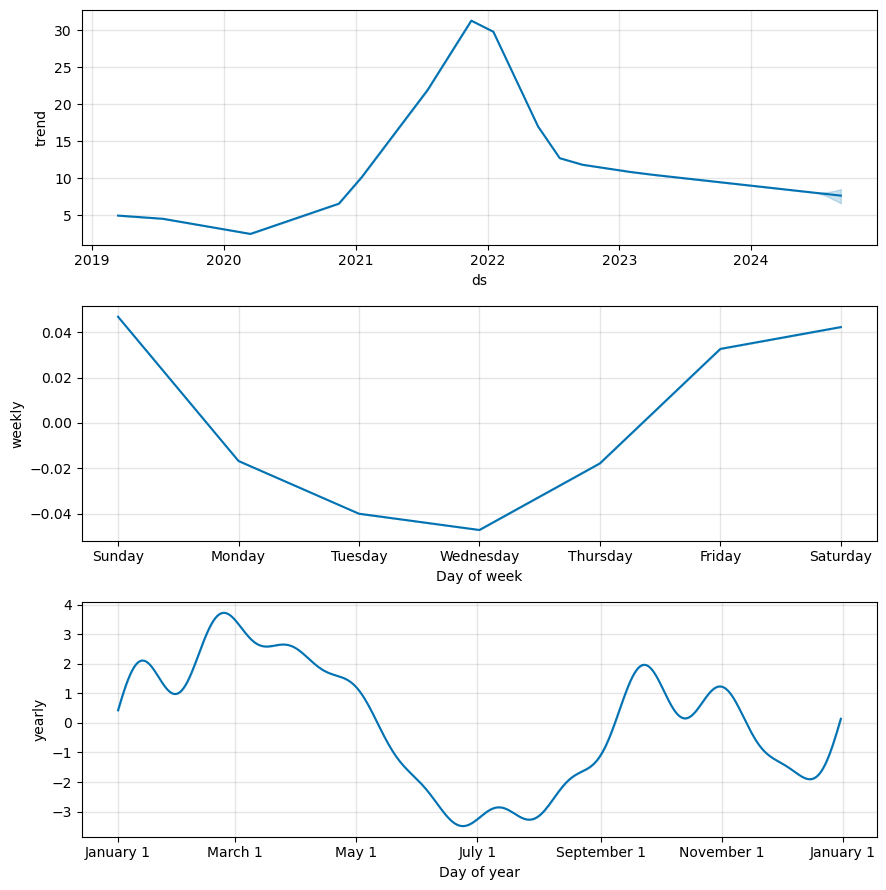

In [38]:
# Use the plot_components function to visualize the forecast results
# for the forecast DataFrame
fig_comp = crypto_model.plot_components(crypto_forecast)
plt.savefig(f'{crypto}_components.png', bbox_inches = 'tight')

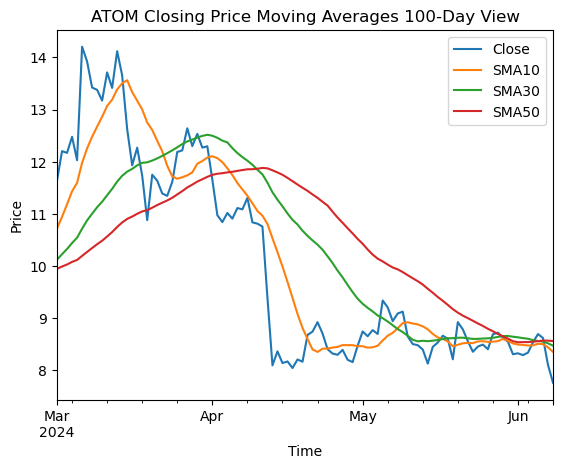

In [39]:
df_last_100 = df_close_ma.iloc[-100:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 100-Day View')    
plt.show()

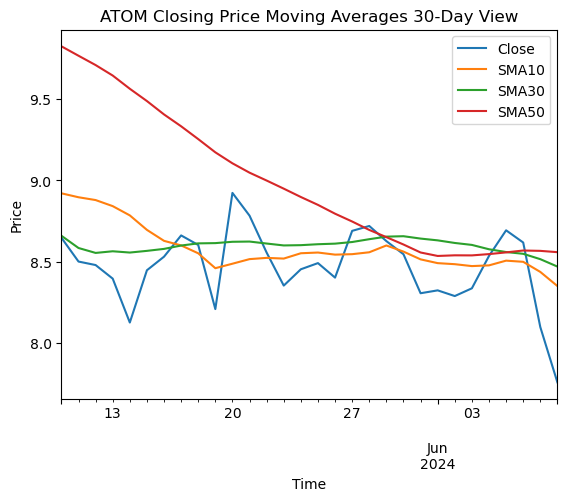

In [40]:
df_last_100 = df_close_ma.iloc[-30:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 30-Day View')    
plt.savefig(f'{crypto}_30d_MA_view.png', bbox_inches = 'tight')
plt.show()

In [41]:
# import module
from datetime import datetime
 
# get current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d")
print("Current date & time : ", current_datetime)
 
# convert datetime obj to string
str_current_datetime = str(current_datetime)
 
# create a file object along with extension
#file_name = f'{crypto} '+str_current_datetime+".txt"
file_name = str_current_datetime+".csv"
file = open(file_name, 'a')
 
print("File created : ", file.name)
file.close()

Current date & time :  2024-06-09
File created :  2024-06-09.csv


In [42]:
f = open(f'{file_name}', "a")
f.writelines([f'{crypto},{last_close_price},{percent_diff_30},{percent_diff_60},{percent_diff_90}\n'])
f.close()

In [43]:
f = open(f'{file_name}', "r")
print(f.read())

ADA,0.43657100200653076,-0.07364667494769794,-0.0009456964793739253,0.3544596118546628
ADA,0.43657100200653076,-0.08437373181845453,0.002834181787628731,0.36173019111251126
ADA,0.43657100200653076,-0.08372637062435029,0.0025919668069758206,0.3631142967037635
ADA,0.43657100200653076,-0.0783190338427533,0.004381382002310641,0.36321329122708335
ATOM,7.759523868560791,-0.2525451407294217,-0.22995154564524733,0.08676291965413196

